# Data 620 - Project 2

Mael Illien, Jeremy O'Brien, Vanita Thompson

### Assignment:

1. Identify a large 2-mode network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3. What can you infer about each of the distinct groups?


### Project Setup

In [1]:
# Import modules
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from itertools import product
import io
from IPython.display import display, HTML
import requests
import warnings
from scipy import stats
from pylab import rcParams
import math
%matplotlib inline

### The Dataset: Kaggle IMBD

We will utilize a [Kaggle dataset of movie data](https://www.kaggle.com/PromptCloudHQ/imdb-data/downloads/imdb-data-from-2006-to-2016.zip/1) that uses IMDB as its source.  It encompasses the thousand most popular movies made between 2006 and 2016, including features like genre, runtime, revenue, and ratings.  Additionally, it includes information on the cast (actors) and crew (directors), which can help to demonstrate connections between different pictures.

For this project we will mine this dataset in order to generate a two-mode network of movies and actors.

In [2]:
# Read CSV into pandas dataframe
url = "https://raw.githubusercontent.com/Vthomps000/DATA620/master/Movies.csv"
s = requests.get(url).content
imdb = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
# Data examples
imdb.head(n=3)

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0


### Data transformation

In order to generate and graph the two-node network, we transform the dataframe so each row connects a Movie with an individual Actor who played in it. These matched pairs of Movie:Actor emulate an edgelist.

In [4]:
# Separate and pivot CSV actor list
mov_actlist = imdb[['Title','Actors']]
mov_act = mov_actlist.applymap(lambda x: x.split(',') if isinstance (x, str) else [x])
mov_act = pd.DataFrame([j for i in mov_act.values for j in product(*i)], columns=['Movie','Actor'])
mov_act.head(n=10).style.hide_index()

Movie,Actor
Guardians of the Galaxy,Chris Pratt
Guardians of the Galaxy,Vin Diesel
Guardians of the Galaxy,Bradley Cooper
Guardians of the Galaxy,Zoe Saldana
Prometheus,Noomi Rapace
Prometheus,Logan Marshall-Green
Prometheus,Michael Fassbender
Prometheus,Charlize Theron
Split,James McAvoy
Split,Anya Taylor-Joy


We generate a graph based on this transformed dataframe.

In [5]:
G_full = nx.from_pandas_edgelist(mov_act,'Movie','Actor')

We perform some diagnostics to ensure that the number of nodes (sum of all movies and unique actors) and edges (total number of movie appearances across the thousand-movie dataset).  

The number of edges corresponds to the number of rows in the transformed dataframe, which is consistent with our expectations.

In [6]:
print(nx.info(G_full))

Name: 
Type: Graph
Number of nodes: 3401
Number of edges: 4035
Average degree:   2.3728


We perform some analysis to help prepare for visualizing the graph.

In [7]:
s = 'Graph is bipartite: {} \nGraph is connected: {} \nNumber of connected components {}'
print(s.format(nx.is_bipartite(G_full), nx.is_connected(G_full), nx.number_connected_components(G_full)))

Graph is bipartite: True 
Graph is connected: False 
Number of connected components 140


Interestingly, our graph is not connected - that is, not every node can be accessed from every other.  This may be a function of the truncation of the thousand-picture subset.  Perhaps there are foreign films in the list that don't intersect cast-wise with other picture, or perhaps some documentaries that don't have credited cast.

### Connected components and subgraphs

In order to perform further analysis and visualization we identify the connected components of the network.

In [8]:
# Identify connected components with greater than five nodes
sorted([len(c) for c in nx.connected_components(G_full) if len(c) > 5], reverse=True)

[2633, 17, 13, 13, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 6, 6]

There are a number of subgraphs in this network. Sixteen of these subgraphs have between 5 and 17 nodes.  By far the largest links 2633 nodes.  This a promising candidate for analysis, and we focus on it for the remainder of this project.

In [9]:
# Function to extract subgraphs
def get_subgraphs(graph):
    
    subgraphs = [(graph.subgraph(c),len(c)) for c in nx.connected_components(graph) if len(c) > 5] # networkx 2.4
    return sorted(subgraphs, key = lambda x: x[1], reverse=True)

# Create connected subgraphs and confirm
subgraphs = get_subgraphs(G_full)
print(*subgraphs[:5], "\n", sep="\n")

# Isolate the largest subgraph
largest_subg = subgraphs[0][0]
largest_subg.graph['name'] = 'Main subgraph'
print(nx.info(largest_subg), "\n")

# Verify largest subgraph is bipartite
G = largest_subg
print('Graph is bipartite: {} \nGraph is connected: {} \n'.format(nx.is_bipartite(G), nx.is_connected(G)))

(<networkx.classes.graph.Graph object at 0x11f9dcb90>, 2633)
(<networkx.classes.graph.Graph object at 0x11f9e5a50>, 17)
(<networkx.classes.graph.Graph object at 0x11f9e5910>, 13)
(<networkx.classes.graph.Graph object at 0x11f9e5b10>, 13)
(<networkx.classes.graph.Graph object at 0x11f9dc110>, 9)


Name: Main subgraph
Type: Graph
Number of nodes: 2633
Number of edges: 3395
Average degree:   2.5788 

Graph is bipartite: True 
Graph is connected: True 



### Visualization

We visualize the largest subgraph of the two-node network, with Movie nodes in blue and Actor nodes in red. 

Given the large number of nodes, it's difficult to discern any meaningful structure.  A periphery is evident, but the core of the network is so dense it appears a literal black hole.

Name: Main subgraph
Type: Graph
Number of nodes: 2633
Number of edges: 3395
Average degree:   2.5788 



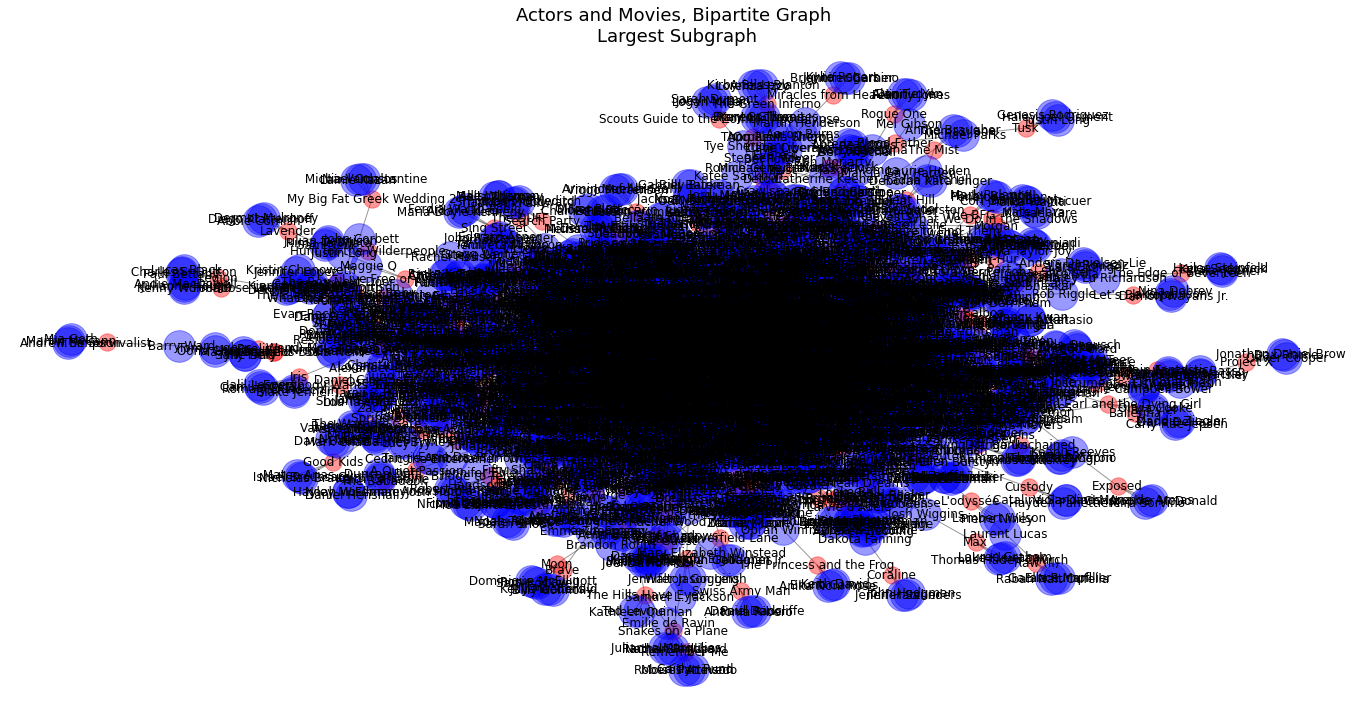

In [10]:
# Function to visualize 2-mode network
def plot_bipartite(graph, title):
    
    # Display graph summary stats
    print(nx.info(graph), "\n")
    
    # Apply plot settings
    warnings.filterwarnings("ignore")
    plt.rcParams["figure.figsize"] = (24,12)
    plt.axis('off')
    pos = nx.spring_layout(graph)
    plt.title(title, fontsize=18)
    
    # Source node labels
    Movies, Actors = nx.bipartite.sets(graph)
    
    # Plot graph by node type
    nx.draw_networkx_nodes(graph, pos, nodelist=Movies, node_color='red', alpha = 0.4)
    nx.draw_networkx_nodes(graph, pos, nodelist=Actors, node_color='blue', alpha = 0.4, node_size = 1000)
    nx.draw_networkx_edges(graph, pos, alpha = 0.4)
    nx.draw_networkx_labels(graph, pos);

# Plot the largest subgraph
title = "Actors and Movies, Bipartite Graph \nLargest Subgraph"
plot_bipartite(G, title)

### Unipartite projection 

We project the bipartite graph as two one-mode network wherein:
1. **Actor network**: actors are nodes linked by edges which are movies
2. **Movie network**: movies are nodes linked by edges which are actors

In [11]:
Movies, Actors = nx.bipartite.sets(G)

Actors = bipartite.weighted_projected_graph(G, Actors, ratio=False)
Actors.graph['name'] = "Actors"

Movies = bipartite.weighted_projected_graph(G, Movies, ratio=False)
Movies.graph['name'] = "Movies"

In [12]:
# Visualize the unipartite graph to identify relationships between actors
#actors = bipartite.weighted_projected_graph(G, Actors, ratio=False)

# Function to extract unipartite graph from bipartite graph and plot it
def convert_bipartite_plot_unipartite(graph, title):
    
    # Display graph summary stats
    print(nx.info(graph), "\n")
    
    # Set node color
    if graph.graph["name"] == "Actors":
        node_color = "blue"
    elif graph.graph["name"] == "Movies":
        node_color = "red"
    else: 
        node_color = 'r'
    
    # Apply plot settings
    warnings.filterwarnings("ignore")
    plt.rcParams["figure.figsize"] = (16,8)
    plt.axis('off')
    pos = nx.spring_layout(graph)
    plt.title(title, fontsize=12)
    
    # Calculate edge weights and node size
    weights = [edata['weight'] for f,t,edata in graph.edges(data=True)]
    node_size = [graph.degree(v)*100 for v in graph] #sizes nodes according to connectedness in first iteration
    
    # Plot graph by node type
    nx.draw_networkx(graph, 
                     k=0.1,
                     iterations=20, 
                     node_size=node_size,
                     node_color=node_color,
                     width=weights, 
                     edge_color=weights,
                     alpha=0.7)
    plt.show()

#### Actors network

Name: Actors
Type: Graph
Number of nodes: 1786
Number of edges: 4915
Average degree:   5.5039 



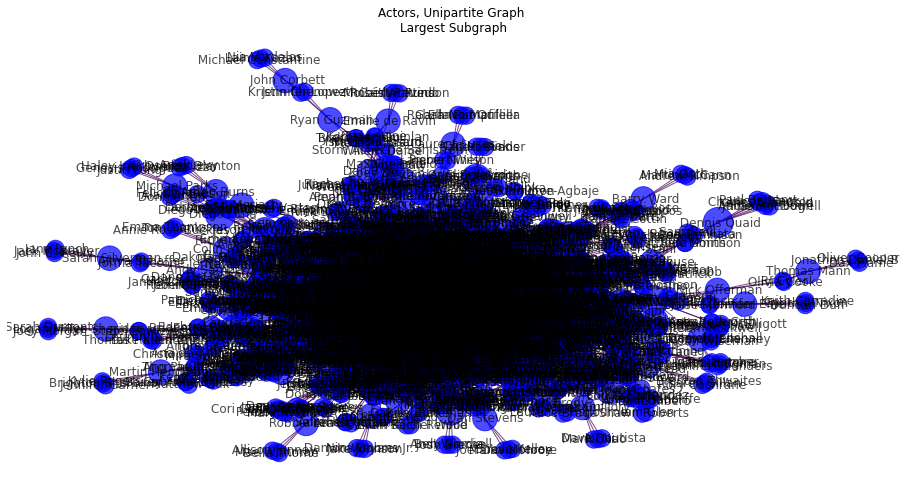

In [13]:
# Visualize the unipartite graph to identify relationships between actors
title = "Actors, Unipartite Graph \nLargest Subgraph"
convert_bipartite_plot_unipartite(Actors, title)

#### Movies network

Name: Movies
Type: Graph
Number of nodes: 847
Number of edges: 3505
Average degree:   8.2763 



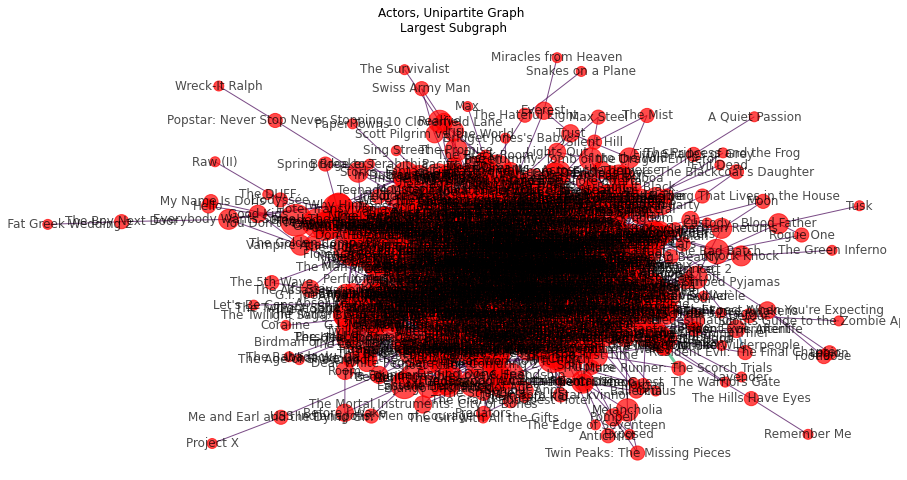

In [14]:
# Visualize the unipartite graph to identify relationships between movies
title = "Actors, Unipartite Graph \nLargest Subgraph"
convert_bipartite_plot_unipartite(Movies, title)

### The Island Method

We use the island method to trim down the subgraph's large size for clearer visualization.  Node trimming is performed based on degree, and edge trimming is performed based on weight.  Implementing the 'Island Method' function provides metrics, specifically the number of nodes and subgraphs that result from trimming at each degree threshold.  This we can use to guide a decision on what node degree to use as a condition for trimming.

In [74]:
# Function to trim nodes based on degree
def trim_nodes(graph, degree=1):
    
    graph_copy = graph.copy() # Copy graph so that original is not altered adn to avoid error below
    
    for (node, val) in graph.degree(): # Must be run on original graph or dictionary will change size during iteration
            if val < degree:
                graph_copy.remove_node(node)
    
    return graph_copy

# Function to trim edges based on weight
def trim_edges(graph, weight=1): 
    
    graph_copy=nx.Graph()
    
    for f, to, edata in graph.edges(data=True): 
        if edata['weight'] > weight:
            graph_copy.add_edge(f,to,**edata)
    
    return graph_copy

# Function to implement island method
def island_method(graph, func=trim_nodes, iterations=5):

    degree = [val for (node, val) in graph.degree()]
    
    mn=int(min(degree))
    mx=int(max(degree))
    step=int((mx-mn)/(iterations))
    
    # List of threshold and trimmed graph pairs
    islands = [[deg_threshold, func(graph, deg_threshold)] for deg_threshold in range(mn,mx,step)]

    for i in islands:
        g_trim = i[1]
        num_nodes = len(g_trim.nodes)
        i.append(num_nodes)
        #num_subgraphs = len(list(nx.connected_component_subgraphs(item[1])))
        num_subgraphs = len([g_trim.subgraph(c) for c in nx.connected_components(g_trim)]) # networkx 2.4
        i.append(num_subgraphs)
    
    return pd.DataFrame(islands, columns = ['Degree Threshold', 'Graph','Number of Nodes', 'Number of Subgraphs'])


# Function to plot trimmed graph based on island method iteration
def draw_islands(df, i):
    
    warnings.filterwarnings("ignore")
    
    G = df['Graph'][i]
    node_size = [G.degree(v)*100 for v in G] #sizes nodes according to connectedness in first iteration
    
    # Set node color
    if G.graph["name"] == "Actors":
        node_color = "blue"
    elif G.graph["name"] == "Movies":
        node_color = "red"
    else: 
        node_color = 'r'
    
    plt.rcParams.update({'font.size': 18})
    plt.rcParams["figure.figsize"] = (24,12)
    plt.axis('off')
    title = str("Island Method Iteration # %d\nThreshold for Inclusion: %s Shared Movie Credits in Dataset" % (i, df['Degree Threshold'][i]))
    plt.title(title)
    
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, 
                     pos=pos, 
                     node_size=node_size, 
                     node_color=node_color,
                     with_labels=False, 
                     alpha=0.8)
    nx.draw_networkx_labels(G, pos=pos, font_size=18, alpha = 0.9)

#### Islands of actors

An analysis of different degree conditions reveals that trimming out actor nodes have five or fewer shared credits with other actors in this set of movies reduces the number of actor nodes from 1786 to 695 without changing the number of subgraphs (one).

In [16]:
# Assess optimal degree threshold for node trimming of actor network
act_islands = island_method(Actors, func=trim_nodes, iterations=8)
act_islands.drop(['Graph'], axis=1).style.hide_index()

Degree Threshold,Number of Nodes,Number of Subgraphs
2,1786,1
5,695,1
8,351,5
11,208,3
14,122,5
17,55,5
20,32,5
23,18,4
26,8,7
29,2,2


When five or more shared credits is the threshold, the network has the following complexion.

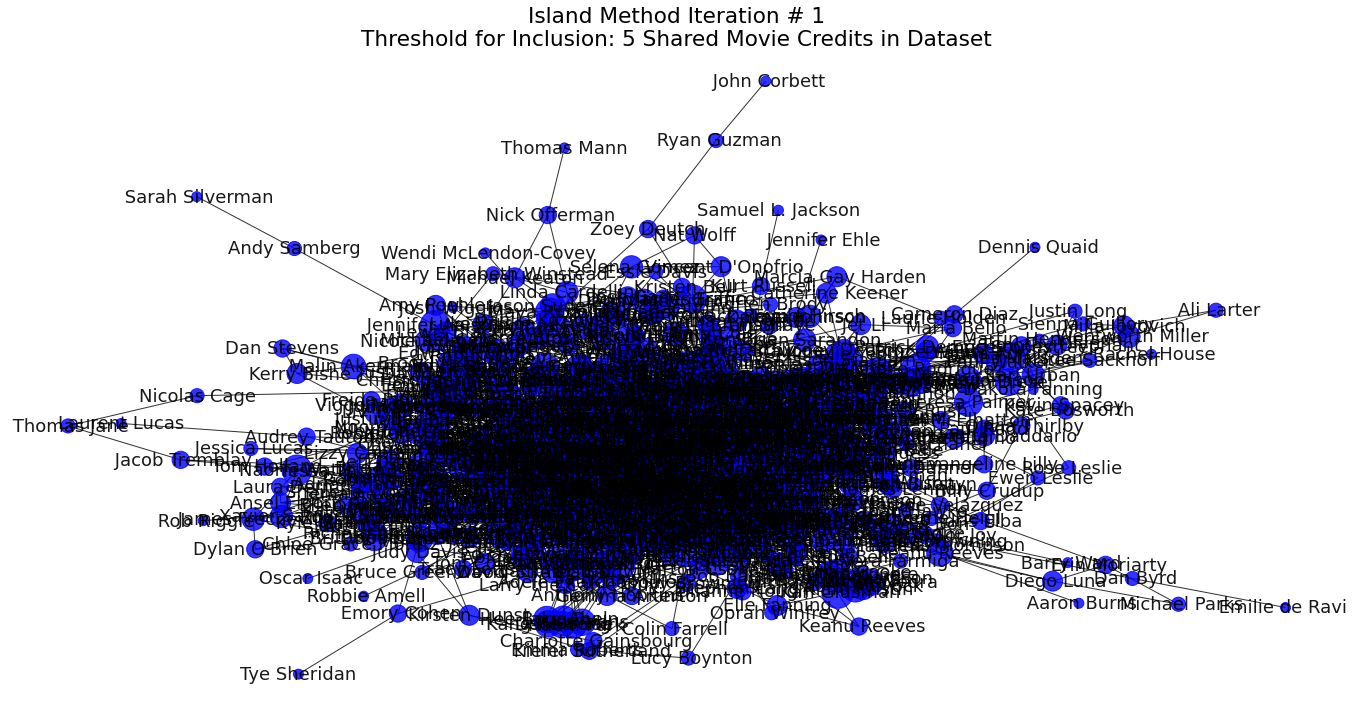

In [17]:
# Plot the 5+ degree actor network
draw_islands(act_islands, 1)

Whereas when twenty or more shared credits is the threshold, the network looks considerably contracted, with five components in total.

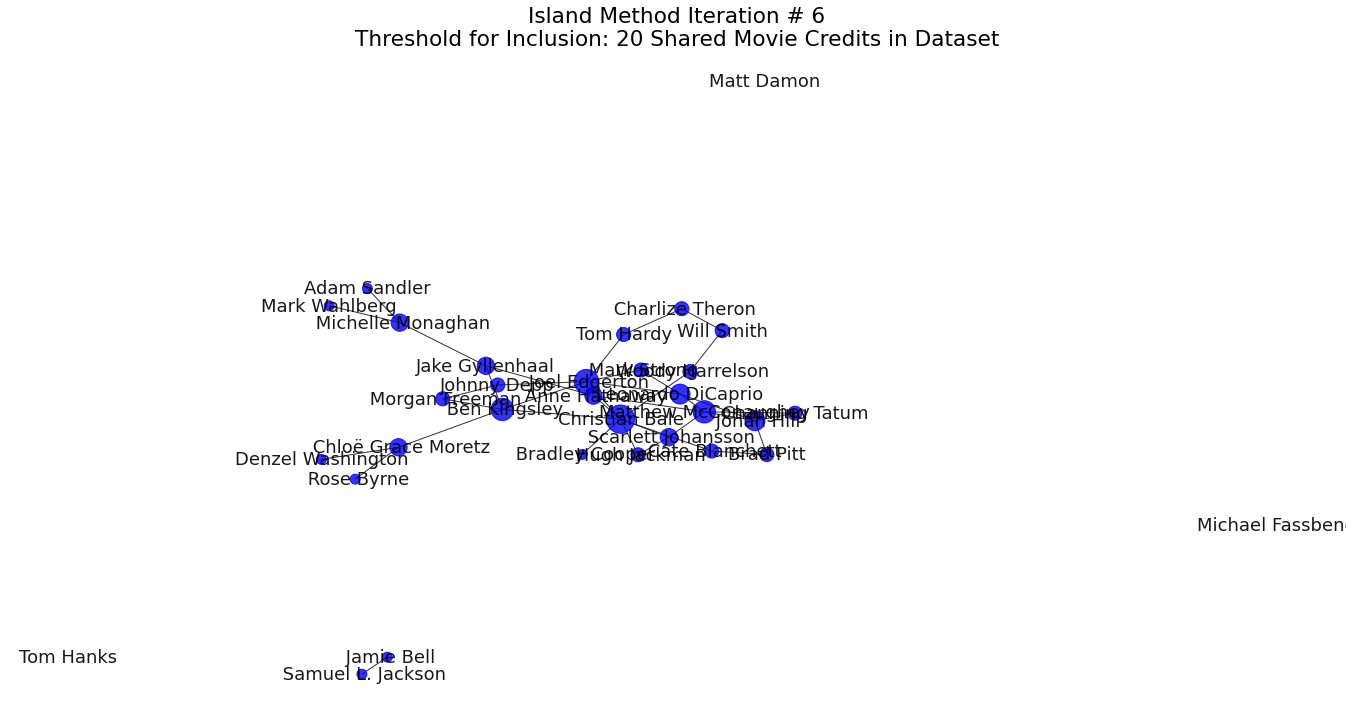

In [18]:
# Plot the 20+ degree threshold actor network
draw_islands(act_islands, 6)

For this project we work with the first iteration, trimming actor nodes that reveal fewer than five shared credits.

In [52]:
# Designate trimmed actor subgraph for analysis and visualization
actors_5 = act_islands['Graph'][1]
actors_5.graph["name"] = "Actors with five or more shared credits"
print(nx.info(actors_5))

Name: Actors with five or more shared credits
Type: Graph
Number of nodes: 695
Number of edges: 2200
Average degree:   6.3309


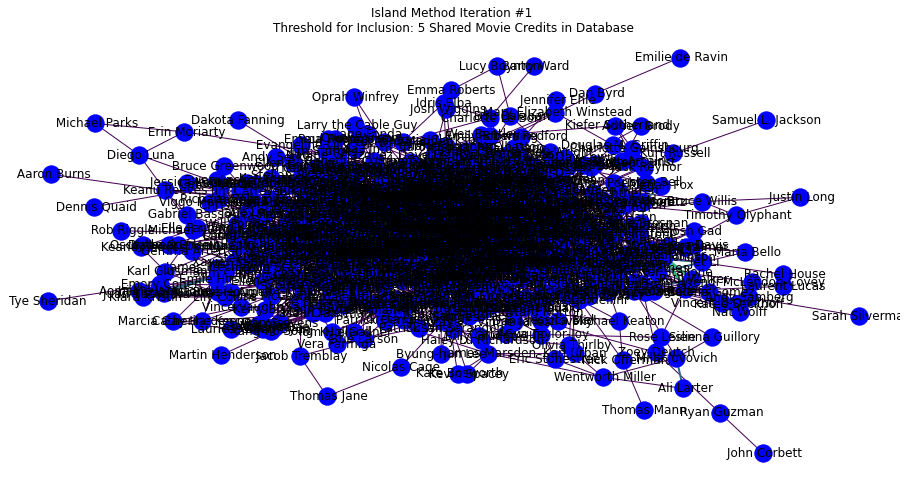

In [20]:
# Visualize the unipartite actor graph to identify relationships between actors
weights = [edata['weight'] for f,t,edata in actors_5.edges(data=True)]
plt.rcParams["figure.figsize"] = (16,8)
nx.draw_networkx(actors_5, 
                 k=0.1,iterations=20, 
                 width=weights,
                 node_color="blue",
                 edge_color=weights)
plt.axis('off')
plt.title(label = "Island Method Iteration #1 \nThreshold for Inclusion: 5 Shared Movie Credits in Database", fontsize=12)
plt.show()

#### Islands of movies

Similar to with the actor graph, we select the movie island subgraph that removes the most nodes without breaking up the network into more subgraphs. For movies in this dataset, this corresponds to the fifth iteration, which reduces the number of movie nodes from 847 to 73 without increasing the number of subgraphs (one).

In [21]:
# Assess optimal degree threshold for node trimming of movie network
mov_islands = island_method(Movies, func=trim_nodes, iterations=8)
mov_islands.drop(['Graph'], axis=1).style.hide_index()

Degree Threshold,Number of Nodes,Number of Subgraphs
1,847,1
4,685,2
7,507,1
10,325,1
13,160,1
16,73,1
19,23,5
22,7,4
25,4,2


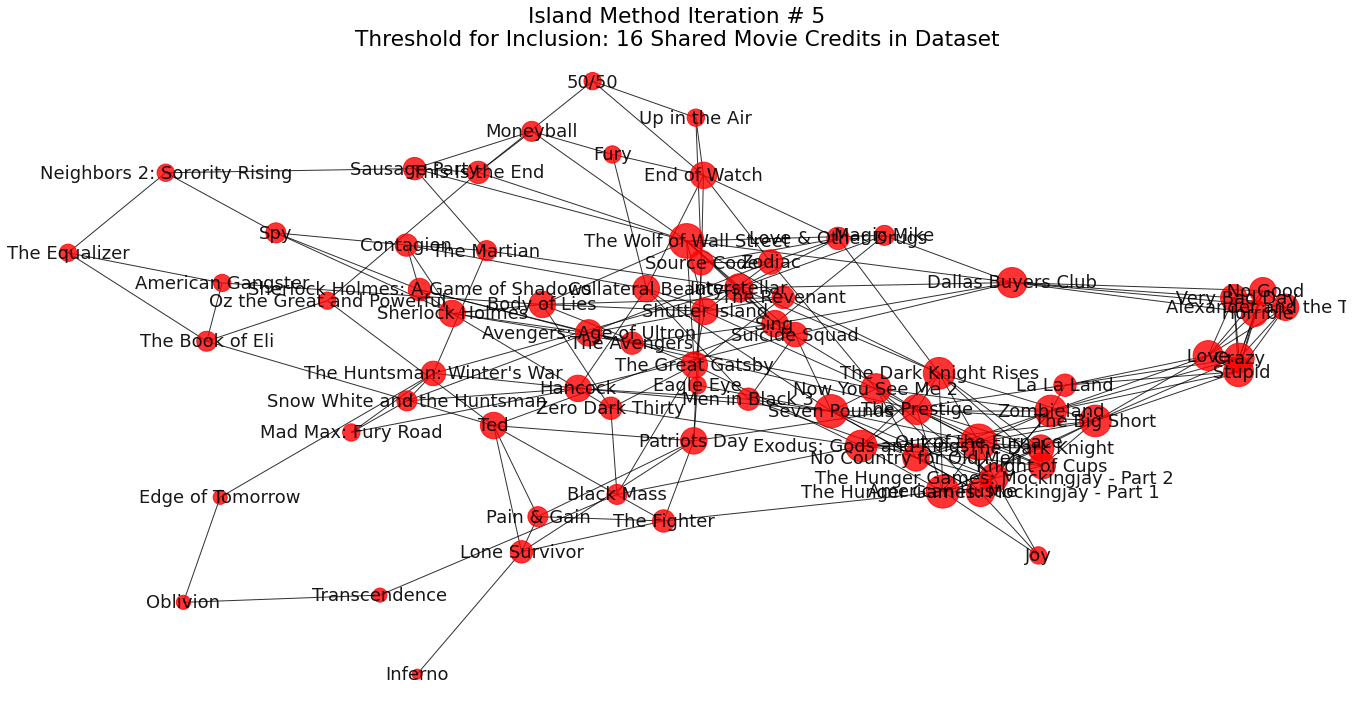

In [22]:
draw_islands(mov_islands,5)

In [23]:
# Designate trimmed movie subgraph for analysis and visualization
movies_16 = mov_islands['Graph'][5]
movies_16.graph["name"] = "Movies with sixteen or more shared credits"
print(nx.info(movies_16))

Name: Movies with sixteen or more shared credits
Type: Graph
Number of nodes: 73
Number of edges: 222
Average degree:   6.0822


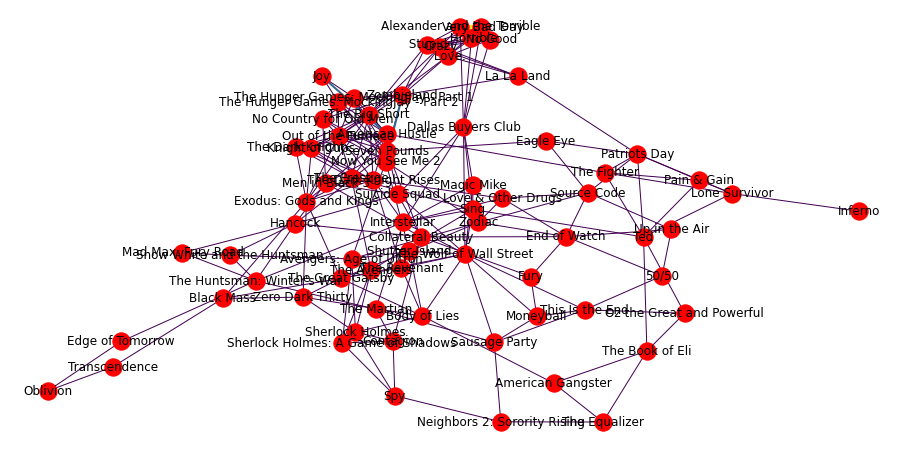

In [24]:
# Visualize the unipartite movie graph to identify relationships between movies
weights = [edata['weight'] for f,t,edata in movies_16.edges(data=True)]
plt.rcParams["figure.figsize"] = (16,8)
nx.draw_networkx(movies_16, 
                 k=0.1,
                 iterations=20, 
                 width=weights, 
                 node_color="red",
                 edge_color=weights)
plt.axis('off')
plt.show()

### Centrality of Actors


Setup for this section needed

In [25]:
def get_metrics(graph):
    
    names = [n for n in graph.nodes()]
    metrics = pd.DataFrame({'name': names})
    degree = nx.degree(graph)
    metrics['degree'] = [degree[n] for n in graph.nodes()]
    betweenness = nx.betweenness_centrality(graph)
    metrics['betweenness'] = [betweenness[n] for n in graph.nodes()]
    closeness = nx.closeness_centrality(graph)
    metrics['closeness'] = [closeness[n] for n in graph.nodes()]
    eigen = nx.eigenvector_centrality_numpy(graph)
    metrics['eigen'] = [eigen[n] for n in graph.nodes()]
    
    return metrics

In [38]:
# Compute centrality metrics for the graph
metrics = get_metrics(actors_5)

In [39]:
metrics.sort_values(by=['degree'], ascending=False).head(n=20).style.hide_index()

name,degree,betweenness,closeness,eigen
Christian Bale,26,0.050675,0.339697,0.220532
Leonardo DiCaprio,22,0.036342,0.319668,0.160927
Mark Wahlberg,22,0.041263,0.308994,0.096206
Matthew McConaughey,22,0.034633,0.319227,0.163255
Will Smith,21,0.029394,0.308719,0.116429
Denzel Washington,20,0.028497,0.312613,0.109144
Jonah Hill,20,0.037712,0.318787,0.130920
Scarlett Johansson,19,0.028122,0.318349,0.140628
Johnny Depp,19,0.022536,0.289287,0.075501
Rose Byrne,19,0.030543,0.301477,0.068465


Degrees here simply captures the number of times a node appears in the dataset. So Wahlberg's in the most of the top 1000 movies from 2006-2016. Between bad action movies and some surprise hit comedies, this makes sense. Movies would show up here only if they had larger casts included in the dataset.

In [40]:
metrics.sort_values(by=['closeness'], ascending=False).head(n=10).style.hide_index()

name,degree,betweenness,closeness,eigen
Christian Bale,26,0.050675,0.339697,0.220532
Joel Edgerton,17,0.025502,0.320406,0.134967
Leonardo DiCaprio,22,0.036342,0.319668,0.160927
Matthew McConaughey,22,0.034633,0.319227,0.163255
Jonah Hill,20,0.037712,0.318787,0.130920
Scarlett Johansson,19,0.028122,0.318349,0.140628
Woody Harrelson,17,0.023492,0.314739,0.132564
Michelle Monaghan,16,0.027676,0.313177,0.093316
Ben Kingsley,16,0.021857,0.312753,0.101221
Denzel Washington,20,0.028497,0.312613,0.109144


Closeness centrality measures a node's ability to communicate with others. In our book's example, these are the gossip mongers. 

From a movie industry perspective, this would be a node's ability to reach all other nodes in the network with fewest edges. Notice that, whereas our distance measure of centers highlighted mostly movies, here we get almost all actors.

In [41]:
metrics.sort_values(by=['betweenness'], ascending=False).head(n=10).style.hide_index()

name,degree,betweenness,closeness,eigen
Christian Bale,26,0.050675,0.339697,0.220532
Mark Wahlberg,22,0.041263,0.308994,0.096206
Jonah Hill,20,0.037712,0.318787,0.130920
Leonardo DiCaprio,22,0.036342,0.319668,0.160927
Matthew McConaughey,22,0.034633,0.319227,0.163255
Chloë Grace Moretz,17,0.030828,0.308307,0.071612
Rose Byrne,19,0.030543,0.301477,0.068465
Charlize Theron,17,0.029792,0.301085,0.082284
Will Smith,21,0.029394,0.308719,0.116429
Denzel Washington,20,0.028497,0.312613,0.109144


Betweenness centrality, according to our textbook, is based on the idea that power resides in bottlenecks between networks. So a cross-genre actor like Hugh Jackman who appears in action films, musicals, and romantic comedies might be an important connector to different groups of actors.

Summing our centrality measures up:



### Centrality of Movies

We start by looking at the degree centrality of the movies network. The list below can be interpretted as movies that have many main characters, and those main characters tend to be celebrities themselves. 

In [42]:
# Compute centrality metrics for movie network
metrics = get_metrics(movies_16)

In [43]:
metrics.sort_values(by=['degree'], ascending=False).head(n=10).style.hide_index()

name,degree,betweenness,closeness,eigen
Out of the Furnace,13,0.046910,0.391304,0.349453
The Wolf of Wall Street,12,0.139416,0.426036,0.073024
American Hustle,11,0.060482,0.376963,0.279813
Seven Pounds,11,0.087057,0.404494,0.192093
The Dark Knight Rises,10,0.056852,0.406780,0.241789
Zombieland,10,0.046836,0.369231,0.227514
The Big Short,10,0.039711,0.369231,0.275643
Exodus: Gods and Kings,10,0.060418,0.387097,0.240113
Dallas Buyers Club,9,0.083613,0.391304,0.091258
Crazy,9,0.015416,0.333333,0.164698


In [44]:
metrics.sort_values(by=['closeness'], ascending=False).head(n=10).style.hide_index()

name,degree,betweenness,closeness,eigen
The Wolf of Wall Street,12,0.139416,0.426036,0.073024
Sing,7,0.077998,0.413793,0.069607
Interstellar,8,0.083248,0.411429,0.071848
The Dark Knight Rises,10,0.056852,0.406780,0.241789
Seven Pounds,11,0.087057,0.404494,0.192093
Shutter Island,7,0.038122,0.393443,0.062599
Dallas Buyers Club,9,0.083613,0.391304,0.091258
The Prestige,9,0.030325,0.391304,0.235120
Out of the Furnace,13,0.046910,0.391304,0.349453
Now You See Me 2,9,0.049253,0.391304,0.181531


In [45]:
metrics.sort_values(by=['betweenness'], ascending=False).head(n=10).style.hide_index()

name,degree,betweenness,closeness,eigen
The Wolf of Wall Street,12,0.139416,0.426036,0.073024
Seven Pounds,11,0.087057,0.404494,0.192093
Dallas Buyers Club,9,0.083613,0.391304,0.091258
Interstellar,8,0.083248,0.411429,0.071848
Ted,7,0.083201,0.351220,0.020979
Sing,7,0.077998,0.413793,0.069607
Patriots Day,7,0.061728,0.339623,0.027782
The Huntsman: Winter's War,6,0.061056,0.344498,0.019841
American Hustle,11,0.060482,0.376963,0.279813
Exodus: Gods and Kings,10,0.060418,0.387097,0.240113


### Cliques

We can now identify cliques in both networks. 

#### Actor cliques

If we observe the list below we recognize that it is mostly dominated by actors who reprise the same roles in movie series have a lot of overlap in their movie resumes and therefore form strong connections. The cliques list below are perfect examples of that:

- Harry Potter (7 movies): 'Daniel Radcliffe', ' Emma Watson', ' Rupert Grint'
- James Bond (4 movies): ' Judi Dench', 'Daniel Craig'
- Fast & Furious (10 movies): ' Dwayne Johnson', ' Paul Walker', 'Vin Diesel' with some variations in cast over the years

In [79]:
actor_cliq = list(nx.find_cliques(trim_edges(actors_5,2)))
actor_cliq

[['Kristen Stewart', ' Taylor Lautner', ' Robert Pattinson'],
 [' Judi Dench', 'Daniel Craig'],
 ['Jennifer Lawrence', ' Liam Hemsworth', ' Josh Hutcherson'],
 ['Jesse Eisenberg', ' Woody Harrelson'],
 [' Emma Watson', 'Daniel Radcliffe', ' Rupert Grint'],
 [' Gwyneth Paltrow', 'Robert Downey Jr.'],
 ['Adam Sandler', ' Kevin James'],
 [' Nick Frost', 'Simon Pegg'],
 [' Dwayne Johnson', ' Paul Walker', 'Vin Diesel'],
 ['Chris Pine', ' Zachary Quinto'],
 [' Josh Duhamel', ' Tyrese Gibson', 'Shia LaBeouf'],
 ['Steve Carell', ' Ryan Gosling', ' Julianne Moore', ' Emma Stone'],
 ['Steve Carell', ' Jennifer Garner', ' Ed Oxenbould', ' Dylan Minnette'],
 [' Theo James', 'Shailene Woodley']]

#### Movie cliques

The movie cliques below goes hand in hand with the above. Some of the movies below are series (Sherlock Holmes, The Hunger Games, Avengers) and others are standalone movies with overlapping casts such as Zombieland & Now You See Me and Joy and American Hustle. 

For example, Jennifer Lawrence is both 'Joy', 'American Hustle'as well as the Hunger Games Series. Robert Downey Jr. is Sherlock Holmes but also one of the Avengers. Marc Ruffalo is in Now You See Me and is the greenest and largest of the Avengers.

This list shows commonalities within the cliques, but also across the cliques.


In [81]:
movie_cliq = list(nx.find_cliques(trim_edges(movies_16,1)))
movie_cliq

[['The Hunger Games: Mockingjay - Part 1',
  'The Hunger Games: Mockingjay - Part 2'],
 [' Stupid', 'Crazy', ' Love.'],
 ['Joy', 'American Hustle'],
 ['Avengers: Age of Ultron', 'The Avengers'],
 ['Alexander and the Terrible', ' Very Bad Day', ' Horrible', ' No Good'],
 ['Zombieland', 'Now You See Me 2'],
 ['Sherlock Holmes', 'Sherlock Holmes: A Game of Shadows']]

### Conclusion

By transforming a large bipartite (2-node) network into individual networks of actors and movies, we were able to extract information about how connected nodes are in these networks. Since the original graph was not fully connected, we started our work by selecting the largest subgraph as the focus of this notebook. After projecting both networks into their unipartite representations, we used the island method trim off less connected nodes. The resulting graphs were of a comfortable size for typical centrality analysis.

The analysis revealed some of the most active actors but also the most connected. We also found when studying cliques in the actors and movies networks that cliques are often form when actors shoot multiple movies of the same series together. By acting in a few series, you are sure to be the most connected actor in Hollywood.

### YouTube

In [85]:
from IPython.display import YouTubeVideo
#YouTubeVideo('')